In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import tqdm
import json
import torch
import warnings
import numpy as np
import torch.nn as nn
from datetime import datetime
import torch.nn.functional as F
import matplotlib.pyplot as plt
from chnet.torchsummary import summary
from torchvision import transforms, utils
from toolz.curried import pipe, curry, compose
from torch.utils.data import Dataset, DataLoader

In [3]:
import utilities as utils
import chnet.cahn_hill as ch
import chnet.ch_tools as tools

In [4]:
from chnet.unet import UNet
from chnet.ch_net import CHnet
from chnet.ch_loader import CahnHillDataset

In [5]:
warnings.filterwarnings('ignore')

In [6]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

def draw_im(im, title=None):
    im = np.squeeze(im)
    plt.imshow(im)
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.show()
    
@curry
def return_slice(x_data, cutoff):
    if cutoff is not None:
        return pipe(x_data,
                    lambda x_data: np.asarray(x_data.shape).astype(int) // 2,
                    lambda new_shape: [slice(new_shape[idim]-cutoff,
                                             new_shape[idim]+cutoff+1)
                                       for idim in range(x_data.ndim)],
                    lambda slices: x_data[slices])
    else:
        return x_data
    
cropper = return_slice(cutoff=5)

In [7]:
def init_unif(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    return np.random.uniform(-0.95, 0.95, size=(nsamples, dim_x, dim_y))


def init_norm(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    means  = np.random.uniform(-0.1, 0.1, size=nsamples)
    np.random.seed(seed)
    scales  = np.random.uniform(0.1, 0.5, size=nsamples)
    
    x_data = [np.random.normal(loc=m, scale=s, size = (1, dim_x, dim_y)) for m,s in zip(means, scales)]
    x_data = np.concatenate(x_data, axis=0)
    
    np.clip(x_data, -0.95, 0.95, out=x_data)
    
    return x_data

## Loss Functions

In [8]:
@curry
def mse_loss(y1, y2, scale=1.):
    """standard MSE definition"""
    return ((y1 - y2) ** 2).sum() / y1.data.nelement() * scale

@curry
def rmse_loss(y1, y2, scale=1.):
    """standard RMSE definition"""
    return ((((y1 - y2) ** 2).sum() / y1.data.nelement()).sqrt()) * scale


def mse_loss_npy(y1, y2):
    """standard MSE definition"""
    return np.sum(((y1 - y2) ** 2)) / y1.size

## Transformers

In [9]:
@curry
def add_neighbors(x):
    dimx = x.shape[0]
    y = np.pad(x, pad_width=[[2,2],[2,2]], mode="wrap")
    out = [x[None]]
    for ix in [0, 1, 2, 3, 4]:
        for iy in [0, 1, 2, 3, 4]:
            out.append((y[ix:ix+dimx, iy:iy+dimx] * x)[None])
    return np.concatenate(out, axis=0)

## Data Generators

In [10]:
@curry
def data_generator(nsamples=128, 
                   dim_x=64, 
                   init_steps=100, 
                   delta_sim_steps = 500,
                   dx = 0.25, 
                   dt = 0.01,
                   gamma=1.0, 
                   seed = None,
                   device = torch.device("cuda:0")):
    
    init_data1 = init_unif(nsamples//2, dim_x, dim_x, seed=seed)
    init_data2 = init_norm(nsamples//2, dim_x, dim_x, seed=seed)
    init_data = np.concatenate([init_data1, init_data2], axis=0)
    
    x_data = ch.ch_run_torch(init_data, dt=dt, gamma=gamma, 
                             dx=dx, sim_step=init_steps, device=device)
    y_data = ch.ch_run_torch(x_data, dt=dt, gamma=gamma, 
                             dx=dx, sim_step=init_steps+delta_sim_steps, device=device)
    return x_data, y_data

In [11]:
x_data, y_data = data_generator(nsamples=16, dim_x=64, 
                                init_steps=10, 
                                delta_sim_steps = 50,
                                dx = 0.25, 
                                dt = 0.01,
                                gamma=1.0, 
                                seed = None,
                                device = torch.device("cuda:0"))

# Set Device

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CNN Model

In [13]:
from chnet.ch_net import CHnet
model = CHnet(in_channels=1, cw=32).to(device)

In [14]:
summary(model, input_size=(1, 104, 104))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 100, 100]             832
            Conv2d-2           [-1, 32, 96, 96]          25,632
            Conv2d-3           [-1, 64, 92, 92]          51,264
            Conv2d-4           [-1, 64, 88, 88]         102,464
            Conv2d-5          [-1, 128, 84, 84]         204,928
            Conv2d-6          [-1, 128, 80, 80]         409,728
            Conv2d-7          [-1, 128, 76, 76]         409,728
            Conv2d-8          [-1, 128, 72, 72]         409,728
            Conv2d-9          [-1, 128, 68, 68]         409,728
           Conv2d-10          [-1, 128, 64, 64]         409,728
           Conv2d-11         [-1, 1024, 64, 64]         132,096
           Conv2d-12         [-1, 2048, 64, 64]       2,099,200
           Conv2d-13            [-1, 1, 64, 64]           2,049
            CHnet-14            [-1, 1,

(tensor(4667105), tensor(4667105))

In [15]:
ks = 5
lx = (ks // 2) * 10 
transformer_x = compose(lambda x: x[None], 
                        lambda x: np.pad(x, pad_width=[[lx,lx],[lx,lx]], mode='wrap'))
transformer_y = lambda x: x[None]

dataset = CahnHillDataset(x_data, y_data, transform_x=transformer_x, transform_y=transformer_y)

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)

print(x.shape, y.shape)

torch.Size([1, 1, 104, 104]) torch.Size([1, 1, 64, 64])


In [16]:
model = CHnet(in_channels=1, cw=32).double().to(device)

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)
y_pred = model(x)

assert y.shape == y_pred.shape
print(mse_loss(y, y_pred).data)

tensor(0.0027, device='cuda:0', dtype=torch.float64)


# Model Training

### Training and Validation data generation

In [18]:
## Process Parameters
dim_x=64
init_steps=10
delta_sim_steps = 2000
dx = 0.25 
dt = 0.01
gamma=1.0

seed_trn = 110364
seed_val = 986423
seed_prd = 284296

n_samples_trn = 1024*10
n_samples_val = 128
n_samples_prd = 32

init_features=32

In [19]:
args = {}
args["dim_x"] = dim_x
args["init_steps"] = init_steps
args["delta_sim_steps"] = delta_sim_steps
args["dx"] = dx
args["dt"] = dt
args["gamma"] = gamma
args["seed_trn"] = seed_trn
args["seed_val"] = seed_val
args["seed_val"] = seed_prd

args["n_samples_trn"] = n_samples_trn
args["n_samples_val"] = n_samples_val
args["n_samples_prd"] = n_samples_prd

args["init_features"] = init_features

In [20]:
%%time
x_trn, y_trn = data_generator(nsamples=n_samples_trn, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_trn,
                                device = device)



x_val, y_val = data_generator(nsamples=n_samples_val, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_val,
                                device = device)

x_prd, y_prd = data_generator(nsamples=n_samples_prd, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_prd,
                                device = device)

CPU times: user 21 s, sys: 17.9 s, total: 38.9 s
Wall time: 37.3 s


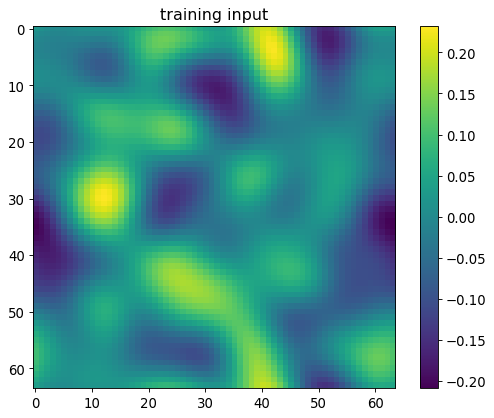

In [21]:
draw_im(x_trn[0], "training input")

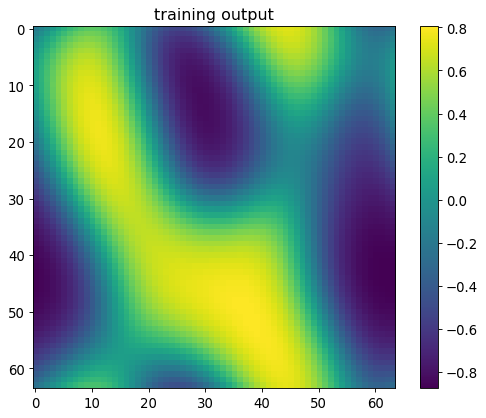

In [22]:
draw_im(y_trn[0], "training output")

In [32]:
ks = 5
lx = (ks // 2) * 10 
transformer_x = compose(lambda x: x[None], 
                        lambda x: np.pad(x, pad_width=[[lx,lx],[lx,lx]], mode='wrap'))
transformer_y = lambda x: x[None]

trn_dataset = CahnHillDataset(x_trn, y_trn, transform_x=transformer_x, transform_y=transformer_y)
val_dataset = CahnHillDataset(x_val, y_val, transform_x=transformer_x, transform_y=transformer_y)
# prd_dataset = CahnHillDataset(x_prd, y_prd, transform_x=transformer_x, transform_y=transformer_y)

batch_size = 4

trn_loader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
# prd_loader = DataLoader(prd_dataset, batch_size=8, shuffle=True, num_workers=1)


total_step = len(trn_loader)
print("No. of training steps: %d" % total_step)
total_val_step = len(val_loader)
print("No. of validation steps: %d" % total_val_step)
total_val_step = len(prd_loader)
print("No. of prediction steps: %d" % total_val_step)

No. of training steps: 2560
No. of validation steps: 32
No. of prediction steps: 4


In [24]:
dt_string = datetime.now().strftime("%d-%m-%Y-%H-%M")

In [25]:
run = 6
run_id = dt_string + "_run_" +str(run)
print(run_id)

folder = "out/unet/ch_unet_id_{}/".format(run_id)
print(folder)

if not os.path.exists(folder):
    os.makedirs(folder)
    
with open(folder+'params.json', 'w') as fp:
    json.dump(args, fp)
    
tag = folder+"unet_"
print(tag)

10-04-2020-21-05_run_6
out/unet/ch_unet_id_10-04-2020-21-05_run_6/
out/unet/ch_unet_id_10-04-2020-21-05_run_6/unet_


In [26]:
from chnet.ch_net import CHnet
model = CHnet(in_channels=1, cw=32).double().to(device)

In [27]:
num_epochs = 20
criterion = mse_loss(scale=10000)
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
trn_losses = []
val_losses = []

In [33]:
torch.cuda.empty_cache()
# Loss and optimizer
for epoch in range(num_epochs):    
    torch.save(model.state_dict(), tag+"epoch_{}.pt".format(epoch))              
    for i, item_trn in enumerate(tqdm.tqdm_notebook(trn_loader)):
        
        
        model.train()
        
        x = item_trn['x'].to(device)
        y_tru = item_trn['y'].to(device)

        # Forward pass
        y_prd = model(x)
        loss = criterion(y_tru, y_prd)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        trn_losses.append(np.sqrt(loss.item()))
        
        if (i) % 512 == 0:
            for item_val in val_loader:
                model.eval()
                x1 = item_trn['x'].to(device)
                y1 = item_trn['y'].to(device)
                # Forward pass
                y2 = model(x1)
                val_losses.append(np.sqrt(criterion(y2, y1).item()))
                    
            print ('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.11f}, Validation Loss: {:.11f}'.format(epoch+1, 
                                                                                                          num_epochs, 
                                                                                                          i+1, 
                                                                                                          total_step, 
                                                                                                          np.mean(trn_losses[-16:]), 
                                                                                                          np.mean(val_losses[-total_val_step:])))
            
# torch.save(model.state_dict(), tag+"epoch_{}.pt".format(num_epochs)) 

Epoch [1/20], Step [1/2560], Training Loss: 43.38103616317, Validation Loss: 43.45116149333
Epoch [1/20], Step [513/2560], Training Loss: 43.53641670191, Validation Loss: 40.47906727694
Epoch [1/20], Step [1025/2560], Training Loss: 42.48583295211, Validation Loss: 41.70471089082
Epoch [1/20], Step [1537/2560], Training Loss: 42.65656058664, Validation Loss: 43.12275099261
Epoch [1/20], Step [2049/2560], Training Loss: 42.43519455127, Validation Loss: 39.02495066423



Epoch [2/20], Step [1/2560], Training Loss: 42.34199808588, Validation Loss: 40.36879740735
Epoch [2/20], Step [513/2560], Training Loss: 42.81667180721, Validation Loss: 43.01203402013
Epoch [2/20], Step [1025/2560], Training Loss: 40.98770923821, Validation Loss: 41.30808920964
Epoch [2/20], Step [1537/2560], Training Loss: 40.94555776063, Validation Loss: 38.26659636980
Epoch [2/20], Step [2049/2560], Training Loss: 40.55586887142, Validation Loss: 37.09176869015



Epoch [3/20], Step [1/2560], Training Loss: 40.86522315563, Validation Loss: 39.86766445640
Epoch [3/20], Step [513/2560], Training Loss: 41.13296050535, Validation Loss: 43.28835833717
Epoch [3/20], Step [1025/2560], Training Loss: 41.06766596259, Validation Loss: 38.06611994974
Epoch [3/20], Step [1537/2560], Training Loss: 39.05847015172, Validation Loss: 38.66516575117
Epoch [3/20], Step [2049/2560], Training Loss: 39.34726836359, Validation Loss: 47.30212033302



Epoch [4/20], Step [1/2560], Training Loss: 39.63457827142, Validation Loss: 38.19261697297
Epoch [4/20], Step [513/2560], Training Loss: 39.95196336028, Validation Loss: 44.59447347582
Epoch [4/20], Step [1025/2560], Training Loss: 37.96002215866, Validation Loss: 37.48999273115
Epoch [4/20], Step [1537/2560], Training Loss: 38.52522817576, Validation Loss: 39.73096304553
Epoch [4/20], Step [2049/2560], Training Loss: 37.30879369999, Validation Loss: 40.70013788977



Epoch [5/20], Step [1/2560], Training Loss: 38.13905849494, Validation Loss: 36.74687453597
Epoch [5/20], Step [513/2560], Training Loss: 36.04570013104, Validation Loss: 36.72493308570
Epoch [5/20], Step [1025/2560], Training Loss: 34.46801811249, Validation Loss: 30.97981082323
Epoch [5/20], Step [1537/2560], Training Loss: 34.45977165128, Validation Loss: 38.96389207869
Epoch [5/20], Step [2049/2560], Training Loss: 33.36128190002, Validation Loss: 30.46259002134



Epoch [6/20], Step [1/2560], Training Loss: 32.19715854603, Validation Loss: 34.34531595457
Epoch [6/20], Step [513/2560], Training Loss: 31.16038691455, Validation Loss: 36.49129303505
Epoch [6/20], Step [1025/2560], Training Loss: 30.33052664124, Validation Loss: 30.20208729769
Epoch [6/20], Step [1537/2560], Training Loss: 29.33997380801, Validation Loss: 31.68164246311
Epoch [6/20], Step [2049/2560], Training Loss: 29.11210956189, Validation Loss: 27.37732000762



Epoch [7/20], Step [1/2560], Training Loss: 28.04028774325, Validation Loss: 25.73494225615
Epoch [7/20], Step [513/2560], Training Loss: 27.48737150941, Validation Loss: 27.86669387948
Epoch [7/20], Step [1025/2560], Training Loss: 27.34945181246, Validation Loss: 33.72600098439
Epoch [7/20], Step [1537/2560], Training Loss: 27.68705855059, Validation Loss: 24.04153544516
Epoch [7/20], Step [2049/2560], Training Loss: 28.07439790231, Validation Loss: 24.58756284345



Epoch [8/20], Step [1/2560], Training Loss: 26.27994394257, Validation Loss: 27.84952359949
Epoch [8/20], Step [513/2560], Training Loss: 26.64411920938, Validation Loss: 25.05752399847
Epoch [8/20], Step [1025/2560], Training Loss: 26.67071684112, Validation Loss: 25.21800185249
Epoch [8/20], Step [1537/2560], Training Loss: 25.91871975052, Validation Loss: 26.76597416373


KeyboardInterrupt: 

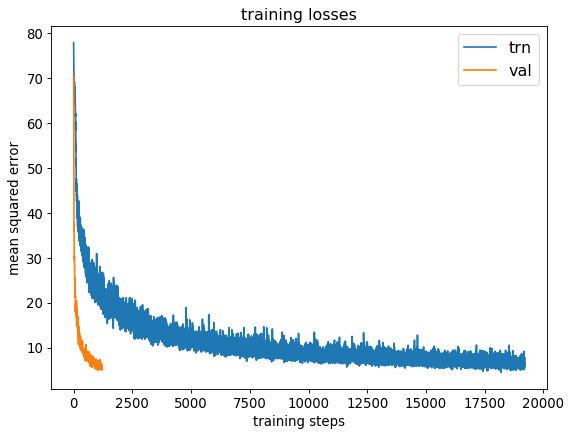

In [44]:
plt.plot(trn_losses)
plt.plot(val_losses)
plt.title("training losses")
plt.xlabel("training steps")
plt.ylabel("mean squared error")
plt.legend(["trn", "val"])
plt.show()

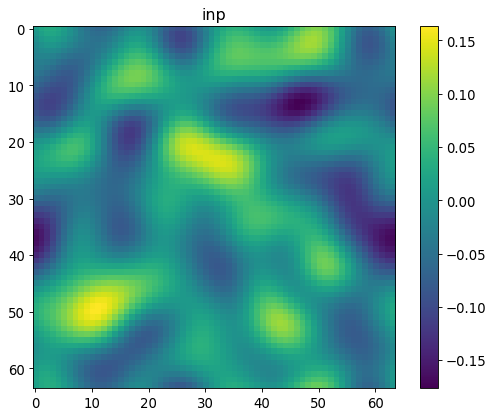

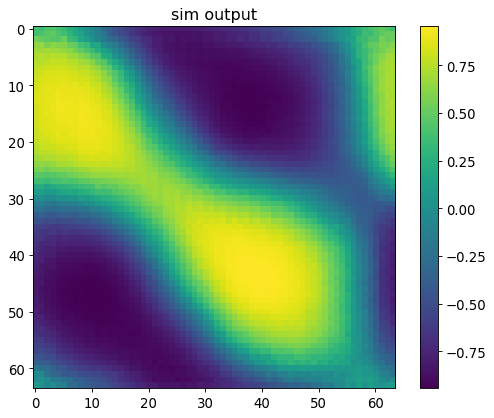

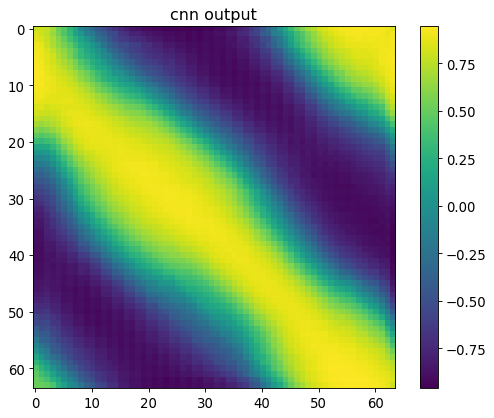

In [48]:
ix = 12

item_prd = prd_dataset[ix]
x1 = item_prd['x'].to(device)
y1 = item_prd['y'].to(device)
y2 = model(y1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1, "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

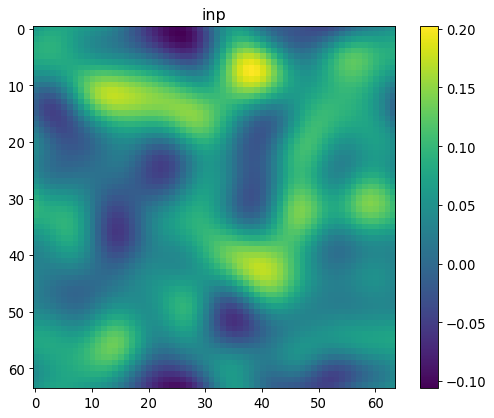

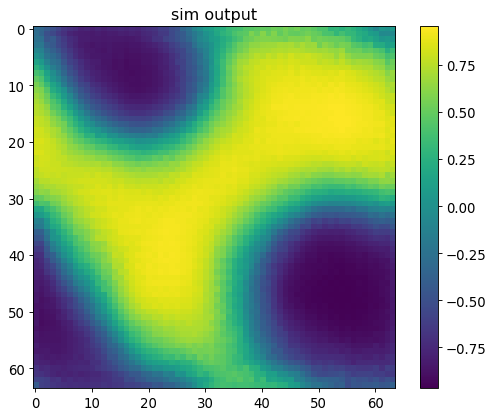

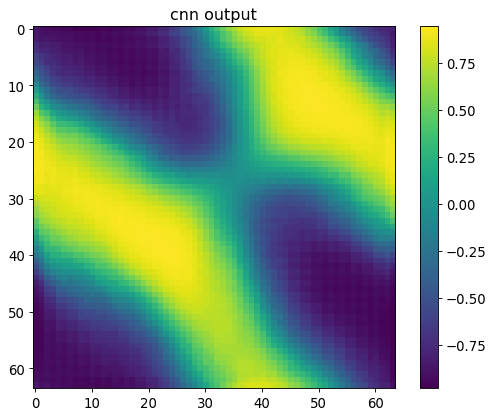

In [49]:
ix = 30

item_prd = prd_dataset[ix]
x1 = item_prd['x'].to(device)
y1 = item_prd['y'].to(device)
y2 = model(y1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1, "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")